In [1]:
import sys
sys.path.append('../')
import sportran as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from scipy.interpolate import CubicSpline, interp1d
def model_scalar(x, y):
    return CubicSpline(np.concatenate([-x[::-1], x[1:]]), np.concatenate([y[::-1], y[1:]]))

n = 2
def model_wishart_(x, y):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    y00, y01, y11 = y.reshape(3,l)
    yy = np.array([[y00, y01], [np.zeros_like(y01), y11]]).T
    # yy = np.einsum('tab,tbc->tac', np.transpose(yy, axes=(0,2,1)), yy)
    yy = np.concatenate([yy[::-1], yy[1:]])
    # return interp1d(xx, yy)) 
    return CubicSpline(xx, yy) #, bc_type = 'clamped')

import numpy as np
from scipy.interpolate import CubicSpline

def model_wishart(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    upper_triangle_indices = np.triu_indices(N)
    y_elements = y.reshape(len(upper_triangle_indices[0]), l)
    
    yy = np.zeros((l, N, N))
    for k, (i, j) in enumerate(zip(*upper_triangle_indices)):
        yy[:, j, i] = y_elements[k]
    
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    
    # y.shape should be l*N**2
    yy = y.reshape(l, N**2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)

def mini_model_w_real(x, y, N):
    xx = np.concatenate([-x[::-1], x[1:]])
    l = x.size
    yy = y.reshape(l, N*(N+1)//2)
    yy = np.concatenate([yy[::-1], yy[1:]])
    return CubicSpline(xx, yy)


In [3]:
dc=np.load('data/bayesian/CsF/dc_minimal.npy', allow_pickle = True).item()

In [4]:
def split_bl(array):
    s = array.shape[0]//2
    return np.hstack([array[:s], array[s:]])

In [5]:
flux = st.HeatCurrent(
    [
        # dc['heat_flux'],
        # dc['electric_flux']
        split_bl(dc['heat_flux']),
        split_bl(dc['electric_flux'])
    ],
    DT_FS=1,
    TEMPERATURE=dc['Temperature'],
    VOLUME=dc['Volume'],
    UNITS='metal'
    )
flux_resample=flux.resample(fstar_THz=20)
flux_resample.filter_psd(0.5)

Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     500.00000 THz
 Resampling freq          f* =      20.00000 THz
 Sampling time         TSKIP =            25 steps
                             =        25.000 fs
 Original  n. of frequencies =         50001
 Resampled n. of frequencies =          2001
 min(PSD)          (pre-filter&sample) =      0.00208
 min(PSD)         (post-filter&sample) =   1856.32621
 % of original PSD Power f<f* (pre-filter&sample)  = 99.365 %
 fPSD not calculated before resampling
 -----------------------------------------------------



In [6]:
flux_resample.maxlike_estimate(
    lambda x, y: mini_model_w_real(x, y, 2), 
    np.arange(5, 7), 
    # 5,
    solver = 'BFGS',
    minimize_kwargs = {
        'tol': 1e-8,
        'jac': '3-point',
        'options': {
            'disp': True, 
            'gtol': 1e-4, 
            'maxiter': 500, 
            'eps': 1e-6
            },
    }
)

MaxLikeFilter Initialization
Maximum-likelihood estimation with n_parameters = [5 6]
Optimal number of parameters between 5 and 6 chosen by AIC
n_parameters = 5
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: 75094.365990
         Iterations: 129
         Function evaluations: 4464
         Gradient evaluations: 144
AIC: -75099.3659903142; Steps since last AIC update: 0
n_parameters = 6
Spline nodes are equispaced from 0 to the Nyquist frequency.
Optimization terminated successfully.
         Current function value: 74936.162065
         Iterations: 158
         Function evaluations: 6290
         Gradient evaluations: 170
AIC: -74942.16206470405; Steps since last AIC update: 0
-----------------------------------------------------
  MAXIMUM LIKELIHOOD ESTIMATION
-----------------------------------------------------
  Fixed n_parameters = 6
  S_{00} =      972767.289072 +/- 44343.082278
  S_{01} =      1

In [61]:
def reweight_alpha_vec(alpha, samples):
    truth_mean = np.mean(samples.T[:,:]*np.exp(-alpha[:, None, None]*np.linalg.norm(samples, axis=1)**2), axis=2)\
    /np.mean(np.exp(-alpha[:, None, None]*np.linalg.norm(samples, axis=1)**2), axis=2)
    truth_var = np.mean(samples.T[:,:]**2*np.exp(-alpha[:, None, None]*np.linalg.norm(samples, axis=1)**2), axis=2)\
    /np.mean(np.exp(-alpha[:, None, None]*np.linalg.norm(samples, axis=1)**2), axis=2)-truth_mean**2
    return truth_mean, truth_var

def reweight_logev_alpha_vec(alpha, samples):
    M = samples.shape[1]
    truth_mean = np.log(np.mean(np.exp(-alpha[:, None]*np.linalg.norm(samples, axis=1)**2), axis=1)) + M/2 * np.log(alpha/2/np.pi)
    return truth_mean

def reweight_alpha(alpha, samples):
    truth_mean = np.mean(samples.T[:,:]*np.exp(-alpha*np.linalg.norm(samples, axis=1)**2), axis=1)\
    /np.mean(np.exp(-alpha*np.linalg.norm(samples, axis=1)**2), axis=0)
    truth_var = np.mean(samples.T[:,:]**2*np.exp(-alpha*np.linalg.norm(samples, axis=1)**2), axis=1)\
    /np.mean(np.exp(-alpha*np.linalg.norm(samples, axis=1)**2), axis=0)-truth_mean**2
    return truth_mean, truth_var

In [62]:
def generate_samples_mc(model, w, omega, omega_fixed, n, cov_w, size=1000):
    sample = w + np.random.multivariate_normal(mean=np.zeros_like(w), cov=cov_w, size=size)
    #sample_S = np.stack([scale_matrix(model, ww, omega, omega_fixed, 2)[:, 1, 0]/scale_matrix(model, ww, omega, omega_fixed, 2)[:, 1, 1] for ww in sample])
    
    return sample

In [63]:
from sportran.md.maxlike import scale_matrix

In [64]:
sampples=generate_samples_mc(flux_resample.maxlike.model,
                             flux_resample.maxlike.parameters_mean,
                             flux_resample.maxlike.omega,
                             flux_resample.maxlike.omega_fixed,
                             flux_resample.N_CURRENTS,
                             flux_resample.maxlike.parameters_cov
                            ) 

In [65]:
sampples.shape

(1000, 18)

In [71]:
dic_alpha={}

alpha = np.linspace(1e-10,1e-5,10000)
dic_alpha['lev_s']=reweight_logev_alpha_vec(alpha=alpha,
                                            samples=sampples
                                              )
dic_alpha['alpha_s'] = alpha[np.argmax(dic_alpha['lev_s'])]
print(dic_alpha['alpha_s'])

[1.00000000e-10 1.10009001e-09 2.10018002e-09 ... 9.99799982e-06
 9.99899991e-06 1.00000000e-05]
[9.99121488e-01 9.90377933e-01 9.81710912e-01 ... 1.73263622e-38
 1.71779560e-38 1.70308213e-38]
1.0261923492349234e-06


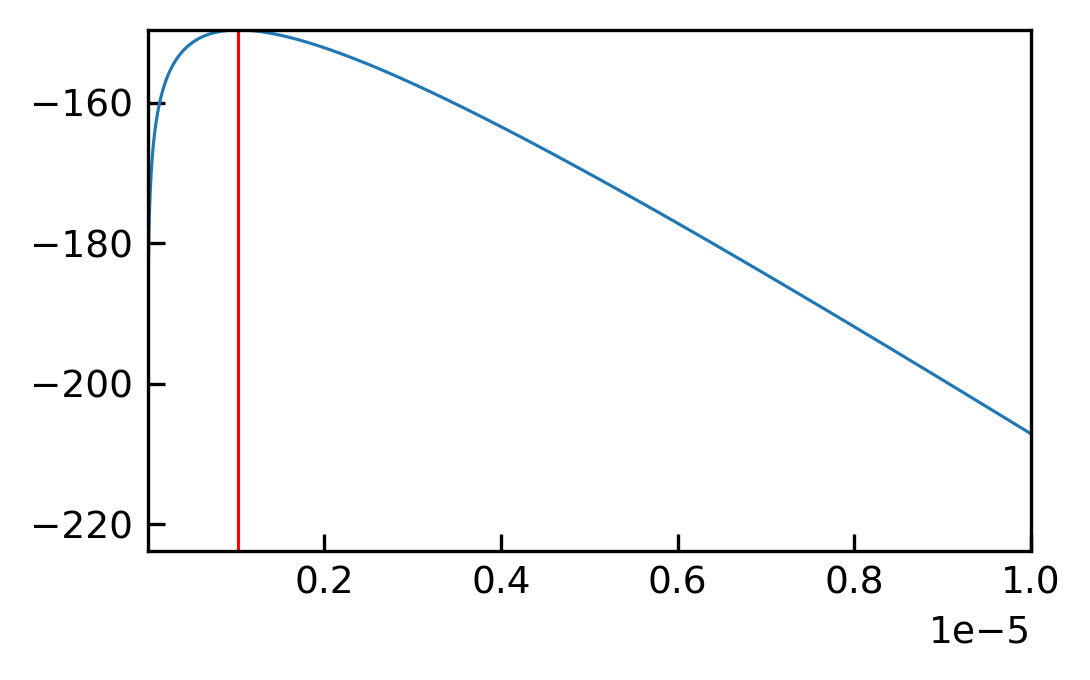

In [73]:
plt.plot(alpha, dic_alpha['lev_s'])
plt.axvline(dic_alpha['alpha_s'], color='red')

In [75]:
new_p, new_std=reweight_alpha(alpha=dic_alpha['alpha_s'], samples=sampples)

In [76]:
new_p, flux_resample.maxlike.parameters_mean

(array([1391.19511519,  238.73263035, 1105.96237317, 1196.97269721,
         309.82950296, 1504.6730606 ,  803.52558311, -120.1150033 ,
         712.445139  ,  551.79621607, -168.6288367 ,  206.4561598 ,
         354.3520938 ,  -81.88368176,   55.50049563,  275.65993193,
         -48.13719587,   21.14055301]),
 array([1394.82421048,  240.77213818, 1107.6120157 , 1196.74135383,
         309.03265131, 1505.47481376,  803.64908998, -120.54241659,
         712.86097633,  551.80037407, -168.58070723,  206.58579703,
         354.31364229,  -81.88612007,   55.5125449 ,  275.97669283,
         -48.16602338,   21.14914733]))